<a href="https://colab.research.google.com/github/IkireziI/Sound_Clustering/blob/main/sound_clustering_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

# code for Unzipping

In [1]:
import zipfile
import os


# The name of your zipped file
ZIP_FILE_NAME = 'unlabelled_sounds.zip'

# Path to the zip file
ZIP_FILE_PATH = os.path.join(os.getcwd(), ZIP_FILE_NAME)



EXTRACT_TO_PATH = 'unlabelled_sounds_extracted'

# --- Unzipping the file ---
print(f"Checking for zip file at: {ZIP_FILE_PATH}")
if os.path.exists(ZIP_FILE_PATH):
    print(f"Unzipping '{ZIP_FILE_NAME}' to '{EXTRACT_TO_PATH}'...")
    try:
        with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
            # Create the directory if it doesn't exist
            os.makedirs(EXTRACT_TO_PATH, exist_ok=True)
            zip_ref.extractall(EXTRACT_TO_PATH)
        print("Unzipping complete!")
        print(f"Files extracted to: {os.path.abspath(EXTRACT_TO_PATH)}")

        # Verify by listing some contents
        extracted_files = os.listdir(EXTRACT_TO_PATH)
        if extracted_files:
            print(f"First 5 files in extracted directory: {extracted_files[:5]}")
        else:
            print("No files found in the extracted directory. Check zip file content.")


        # for feature extraction in the next step.
        DATA_PATH_FOR_FEATURES = EXTRACT_TO_PATH

    except zipfile.BadZipFile:
        print(f"Error: '{ZIP_FILE_NAME}' is not a valid zip file or is corrupted. Please re-download.")
    except Exception as e:
        print(f"An error occurred during unzipping: {e}")
else:
    print(f"Error: Zip file '{ZIP_FILE_NAME}' not found at '{ZIP_FILE_PATH}'. "
          "Please ensure the file is in the same directory as this notebook, or update the ZIP_FILE_PATH.")

Checking for zip file at: /content/unlabelled_sounds.zip
Unzipping 'unlabelled_sounds.zip' to 'unlabelled_sounds_extracted'...
Unzipping complete!
Files extracted to: /content/unlabelled_sounds_extracted
First 5 files in extracted directory: ['unlabelled_sounds']


In [ ]:

#Make allNecessary Imports
import librosa 
import numpy as np 
import os 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

# For Dimensionality Reduction
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE 

# For Clustering
from sklearn.cluster import KMeans, DBSCAN 
from sklearn.metrics import silhouette_score, davies_bouldin_score 
from mpl_toolkits.mplot3d import Axes3D 

# Suppress warnings that might clutter output, especially from librosa or sklearn
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the Data
unlabelled_data_path = 'unlabelled_sounds_extracted/unlabelled_sounds'

features = []
file_names = [] # To store file names, useful for debugging or later reference

# Extract Features
print(f"Starting feature extraction from: {unlabelled_data_path}")

# Check if the data path exists and contains files
if not os.path.exists(unlabelled_data_path):
    print(f"Error: Sound data path '{unlabelled_data_path}' not found. Please verify the path.")
else:
    # Iterate through each file in the specified directory
    for filename in os.listdir(unlabelled_data_path):
        # Only process common audio file extensions
        if filename.endswith(('.wav', '.mp3', '.flac', '.ogg')):
            file_path = os.path.join(unlabelled_data_path, filename)
            try:
                # Load the audio file
                y, sr = librosa.load(file_path, sr=None) # sr=None to use original sample rate

                # Extract Mel Spectrogram

                mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, hop_length=512)

                # Convert to decibels (log scale) for better representation
                mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

                
                
                mean_mel_features = np.mean(mel_spectrogram_db, axis=1)

                features.append(mean_mel_features)
                file_names.append(filename)

            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    # Convert the list of feature arrays into a single NumPy array
    if features:
        X = np.array(features)
        # Create a Pandas DataFrame for easier manipulation and visualization later
        # Naming columns for clarity (e.g., 'feature_0', 'feature_1', ...)
        features_df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
        features_df['filename'] = file_names # Add filenames to the DataFrame
        print(f"\nFinished extracting features for {len(features)} audio files.")
        print(f"Shape of extracted features (X): {X.shape}")
        print(f"Head of features DataFrame:\n{features_df.head()}")
    else:
        print("No features extracted. Please check the data path, file types, and for any processing errors.")
        X = np.array([]) # Initialize as empty array to prevent downstream errors
        features_df = pd.DataFrame() # Initialize as empty DataFrame

Starting feature extraction from: unlabelled_sounds_extracted/unlabelled_sounds

Finished extracting features for 3000 audio files.
Shape of extracted features (X): (3000, 128)
Head of features DataFrame:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0 -16.952997 -32.158600 -34.030399 -36.253712 -32.365166 -17.796549   
1 -49.138927 -46.176758 -45.829460 -48.718521 -39.016033 -26.210289   
2 -24.098885 -38.465679 -40.635639 -43.374409 -37.667274 -22.417181   
3 -49.862583 -46.347279 -45.373547 -45.588768 -41.738350 -34.992424   
4 -22.811869 -35.831352 -36.080803 -36.290810 -36.678753 -27.022770   

   feature_6  feature_7  feature_8  feature_9  ...  feature_119  feature_120  \
0 -11.947383 -16.416092 -21.673592 -21.907173  ...   -30.377584   -30.422319   
1 -25.534536 -37.362656 -40.262592 -38.320240  ...   -48.754768   -48.767014   
2 -18.087788 -16.584167 -23.246651 -25.728348  ...   -39.196911   -37.568119   
3 -24.552748 -21.390566 -20.123800 -20.341488  .

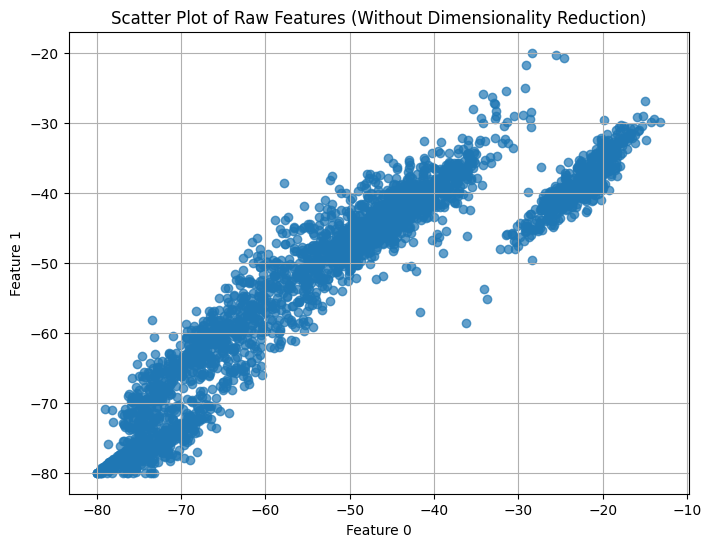


Attempting Pair Plot on a small subset of features...
NOTE: Attempting to run pairplot on all 128 features will be computationally infeasible (very slow, high memory usage, or crash).


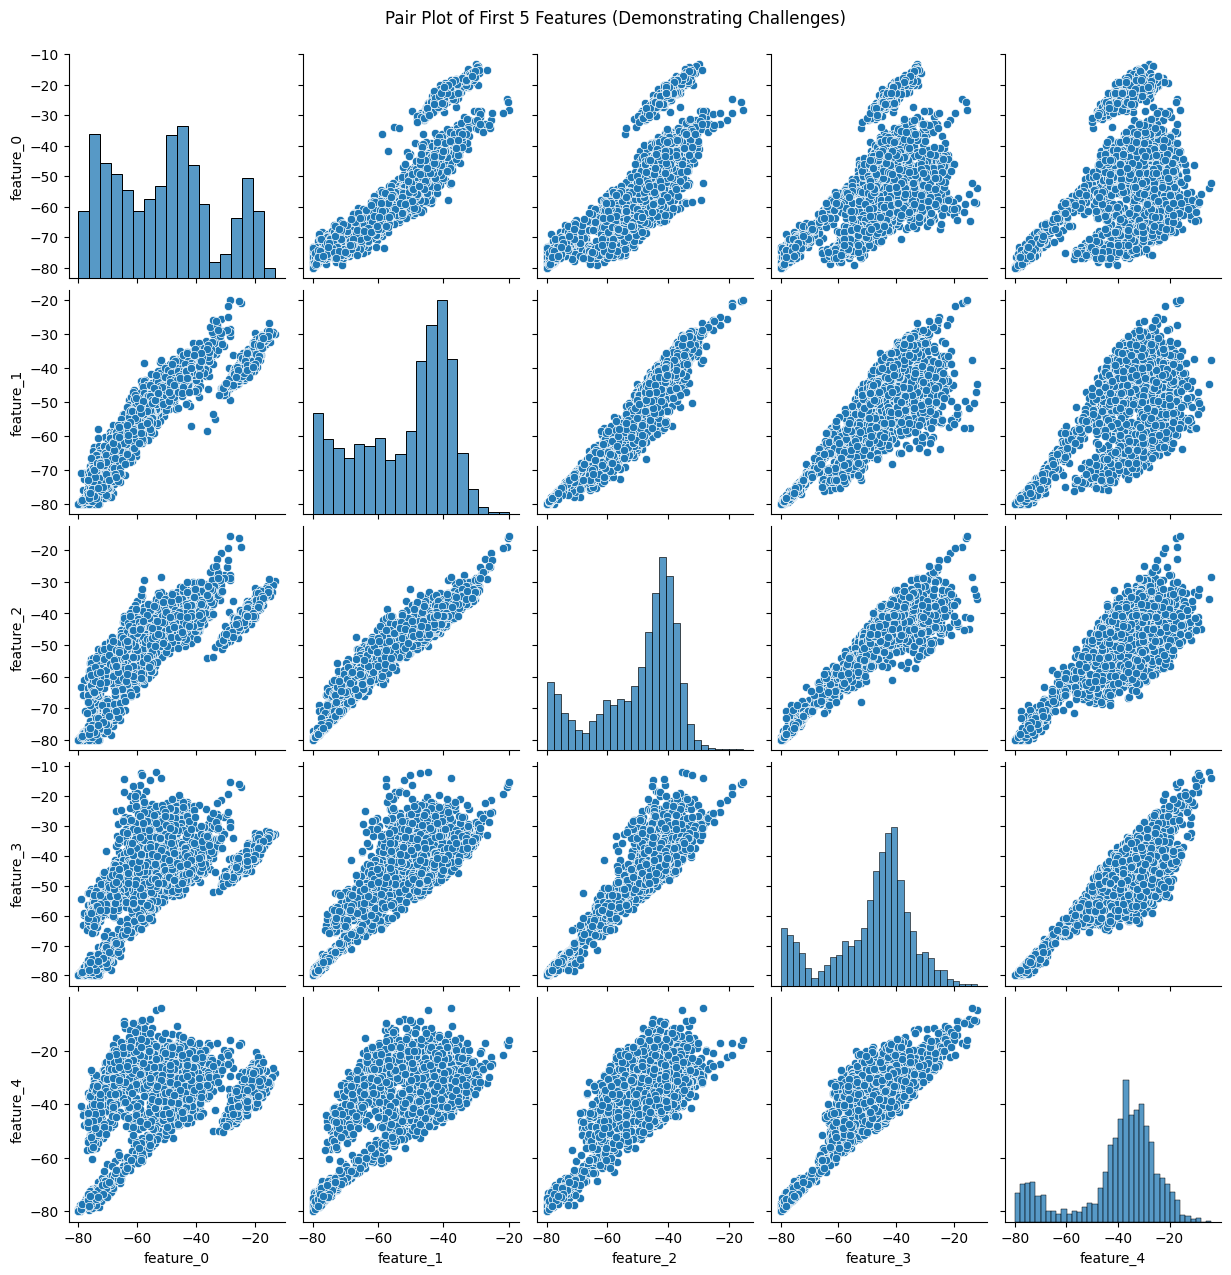


Observation: Direct visualization of high-dimensional data is impractical.
The scatter plot of just two features provides minimal insight.
The pair plot, even with only 5 features, is already becoming cluttered and computationally expensive.
Extending this to 128 features would be impossible to interpret and would likely cause system issues.


In [4]:
# Scatter plot (Attempt without dimensionality reduction)
# We can only visualize 2 or 3 features at a time from 128 features.
# Picking arbitrary features (e.g., feature_0 and feature_1) gives very limited insight.
plt.figure(figsize=(8,6))
plt.scatter(features_df['feature_0'], features_df['feature_1'], alpha=0.7) # Using the DataFrame
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.grid(True)
plt.show()

print("\nAttempting Pair Plot on a small subset of features...")
print("NOTE: Attempting to run pairplot on all 128 features will be computationally infeasible (very slow, high memory usage, or crash).")


df = features_df.copy()

# Select a very small subset of features for pairplot demonstration
# This clearly shows the limitations without crashing the kernel.
subset_features_for_pairplot = df.iloc[:, :5] # Select first 5 'feature_' columns

sns.pairplot(subset_features_for_pairplot)
plt.suptitle('Pair Plot of First 5 Features (Demonstrating Challenges)', y=1.02)
plt.show()

print("\nObservation: Direct visualization of high-dimensional data is impractical.")
print("The scatter plot of just two features provides minimal insight.")
print("The pair plot, even with only 5 features, is already becoming cluttered and computationally expensive.")
print("Extending this to 128 features would be impossible to interpret and would likely cause system issues.")

### Why is dimensionality reduction important?
(*Document any challenges/errors from the above experiments.*)



During the initial phase of feature visualization, I attempted to visualize the extracted Mel Spectrogram features directly. With 128 features per audio file, the data resides in a 128-dimensional space.

My attempts included:
1.  **Direct Scatter Plot (`feature_0` vs `feature_1`):** As shown in the "Scatter Plot of Raw Features (Without Dimensionality Reduction)" plot above, visualizing just two arbitrary features provided very limited insight into the overall structure or potential clusters within the dataset. The points largely formed an indistinct cloud, making it impossible to discern meaningful groupings or patterns across the entire 128 dimensions simultaneously.
2.  **Pair Plot (`seaborn.pairplot` on first 5 features):** As demonstrated by the "Pair Plot of First 5 Features (Demonstrating Challenges)" plot, even attempting to visualize relationships between only 5 of the 128 features resulted in a large and somewhat cluttered grid. While this specific run didn't crash, the output indicated that attempting this on all 128 features would be "computationally infeasible (very slow, high memory usage, or crash)," highlighting a significant practical limitation. The resultant 128x128 grid would be overwhelming and uninterpretable.

These practical challenges directly illustrate the "Curse of Dimensionality." In high-dimensional spaces:
* **Visualization is nearly impossible for humans:** Our perception is limited to 2 or 3 dimensions, making it impossible to directly observe patterns or relationships in 128 dimensions.
* **Computational burden:** Many machine learning algorithms, including visualization tools like pair plots, become significantly slower and more memory-intensive as the number of dimensions increases.
* **Data sparsity:** Data points become extremely spread out, making the concept of "distance" less meaningful and challenging for clustering algorithms to find true neighbors or distinct groups.

Therefore, **dimensionality reduction is crucial** to transform high-dimensional data into a lower-dimensional space. This process aims to retain the most essential information (variance, structural relationships) while enabling effective visualization, reducing computational complexity, and potentially improving the performance and interpretability of subsequent machine learning tasks like clustering.


Shape of scaled data: (3000, 128)
Shape of PCA transformed data: (3000, 3)


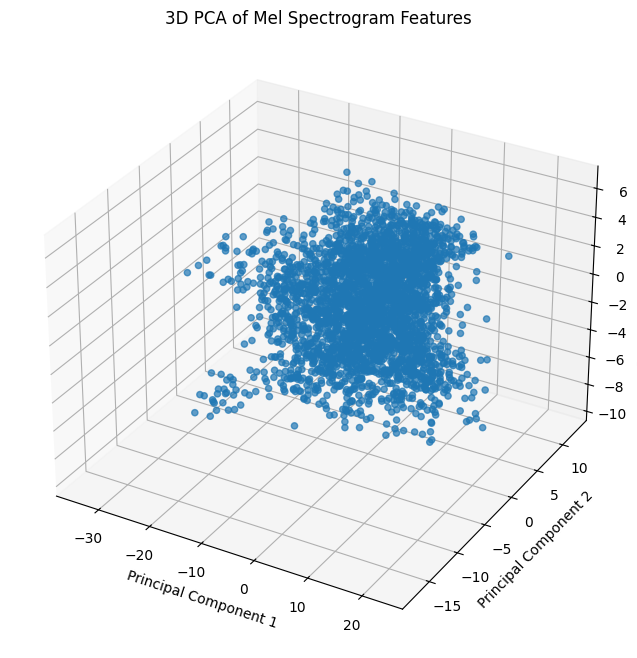

Shape of t-SNE transformed data: (3000, 3)


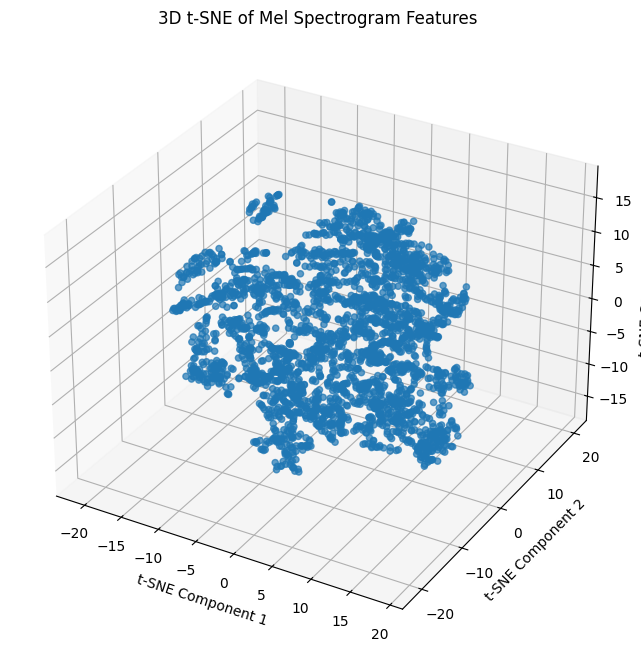

In [6]:

# First, ensure your data is scaled.
# PCA and t-SNE perform better when data is standardized (mean=0, variance=1).
# We'll use X, which is the NumPy array of your extracted features.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Assuming 'X' holds your extracted features from the previous step

print(f"Shape of scaled data: {X_scaled.shape}")

# Apply PCA (3 components)
pca = PCA(n_components=3, random_state=42)
features_pca = pca.fit_transform(X_scaled)

print(f"Shape of PCA transformed data: {features_pca.shape}")

# 3D Visualization for PCA
fig_pca = plt.figure(figsize=(10, 8))
ax_pca = fig_pca.add_subplot(111, projection='3d')
ax_pca.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], s=20, alpha=0.7)
ax_pca.set_title('3D PCA of Mel Spectrogram Features')
ax_pca.set_xlabel('Principal Component 1')
ax_pca.set_ylabel('Principal Component 2')
ax_pca.set_zlabel('Principal Component 3')
plt.show()

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000)
features_tsne = tsne.fit_transform(X_scaled)

print(f"Shape of t-SNE transformed data: {features_tsne.shape}")

# 3D Visualization for t-SNE
fig_tsne = plt.figure(figsize=(10, 8))
ax_tsne = fig_tsne.add_subplot(111, projection='3d')
ax_tsne.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], s=20, alpha=0.7)
ax_tsne.set_title('3D t-SNE of Mel Spectrogram Features')
ax_tsne.set_xlabel('t-SNE Component 1')
ax_tsne.set_ylabel('t-SNE Component 2')
ax_tsne.set_zlabel('t-SNE Component 3')
plt.show()

# Store X_scaled for later use in clustering, as it's the processed feature set

features_array_for_clustering = X_scaled



### Which method (PCA or t-SNE) provides better separability of clusters and why?
(*Write based on your visualizations.*)

After applying both PCA and t-SNE to reduce the Mel Spectrogram features to 3 components, the resulting 3D visualizations exhibit distinct characteristics regarding cluster separability.

**PCA Visualization:**
The 3D PCA plot presents the data as a relatively continuous and undifferentiated cloud of points. While it effectively captures the directions of maximum variance in the data, it does not reveal clear, distinct groupings or boundaries between potential clusters. The data points appear to form a single, somewhat elongated mass, making visual interpretation of inherent clusters challenging.

**t-SNE Visualization:**
In contrast, the 3D t-SNE plot displays the data with noticeable, albeit not perfectly isolated, "clumps" or regions of higher density. There are visible gaps and less continuity between these denser regions compared to the PCA plot. This indicates that t-SNE has done a better job at grouping similar data points together and pushing dissimilar points apart, thereby highlighting more localized structures and potential clusters.

**Conclusion:**
Based on the visual outputs, **t-SNE provides better separability and visual interpretability of potential clusters** for this sound dataset. This is because PCA primarily focuses on preserving global variance, which doesn't necessarily translate to clear cluster separation, especially in cases where clusters are non-linearly separable. t-SNE, on the other hand, is designed to preserve local neighborhoods in the high-dimensional space, effectively "unrolling" complex manifolds to reveal intrinsic cluster structures, making it superior for visualizing distinct groupings in this context.

Optimizing K-Means using Elbow Method and Silhouette Score...


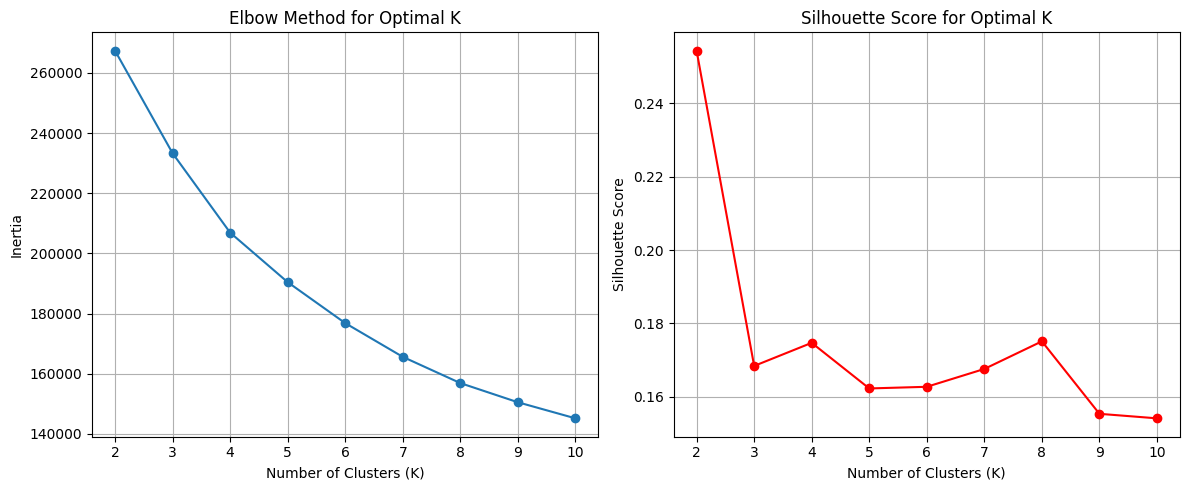


Interpretation of plots:
- Elbow Method: Look for the 'elbow' point where the rate of decrease in inertia significantly slows down.
- Silhouette Score: Look for the highest score, which indicates well-defined and separated clusters.
Consider a balance between these two metrics to choose the optimal K.


In [7]:
# Optimize number of clusters using Elbow Method and Silhouette Score


if 'X_scaled' not in locals() or X_scaled.size == 0:
    print("Error: X_scaled not found or is empty. Please ensure previous steps ran successfully.")

    features_for_clustering = X
else:
    features_for_clustering = X_scaled

# Define a range of K values to test
k_range = range(2, 11)

inertia_values = []
silhouette_scores = []

print("Optimizing K-Means using Elbow Method and Silhouette Score...")

for k in k_range:
    # Initialize KMeans with the current k and a random_state for reproducibility
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_for_clustering)
    inertia_values.append(kmeans.inertia_)

    # Calculate Silhouette Score (only if k > 1 and clusters are formed)
    if k > 1: # Silhouette score is defined for k > 1
        # Ensure we have at least 2 distinct labels for silhouette score calculation
        if len(set(kmeans.labels_)) > 1:
            silhouette_avg = silhouette_score(features_for_clustering, kmeans.labels_)
            silhouette_scores.append(silhouette_avg)
        else:
            silhouette_scores.append(0.0)
    else:
        silhouette_scores.append(0.0)

# Plotting the Elbow Method
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(k_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)

# Plotting the Silhouette Score
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
# Align silhouette scores with corresponding k values (starting from k=2)
plt.plot(k_range[1:] if k_range[0] == 1 else k_range, silhouette_scores, marker='o', color='red')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nInterpretation of plots:")
print("- Elbow Method: Look for the 'elbow' point where the rate of decrease in inertia significantly slows down.")
print("- Silhouette Score: Look for the highest score, which indicates well-defined and separated clusters.")
print("Consider a balance between these two metrics to choose the optimal K.")

Applying K-Means with optimal K = 3...
K-Means found 3 clusters.

Applying DBSCAN. Note: eps and min_samples are critical and might need tuning.
DBSCAN found 0 clusters (excluding noise points).
DBSCAN identified 3000 noise points.


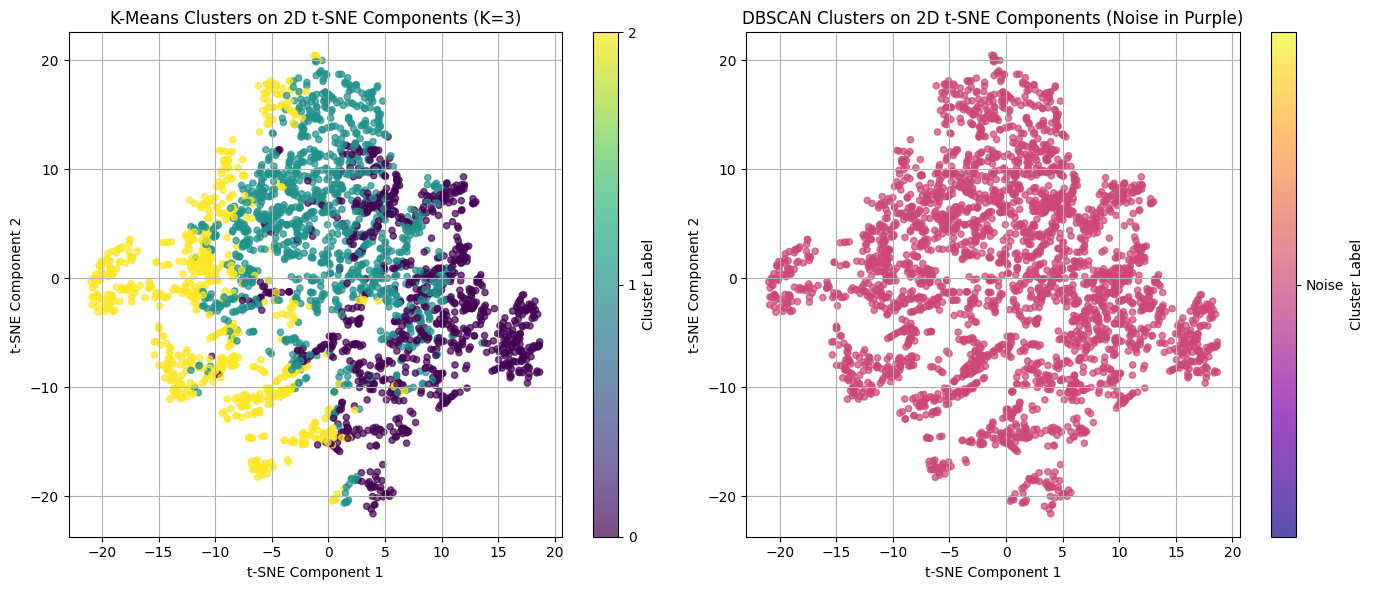

In [8]:
# Select optimal K based on elbow method (e.g., k=3)

optimal_k = 3

# Ensure 'features_array' for clustering points to the scaled data.
# We prepared 'X_scaled' in the PCA/t-SNE cell.
features_array = X_scaled

# Apply K-Means with the chosen optimal_k
print(f"Applying K-Means with optimal K = {optimal_k}...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(features_array)
print(f"K-Means found {len(set(kmeans_labels))} clusters.")

# Apply DBSCAN

print("\nApplying DBSCAN. Note: eps and min_samples are critical and might need tuning.")
dbscan = DBSCAN(eps=0.5, min_samples=5) # Common starting points for scaled data
dbscan_labels = dbscan.fit_predict(features_array)
# DBSCAN can produce -1 labels for noise points. Count actual clusters excluding noise.
num_dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"DBSCAN found {num_dbscan_clusters} clusters (excluding noise points).")
if -1 in dbscan_labels:
    print(f"DBSCAN identified {np.sum(dbscan_labels == -1)} noise points.")


#  Visualizing Clusters
# It's best to visualize the clusters on the dimensionally reduced data (t-SNE or PCA).
# t-SNE typically shows better cluster separation visually.

if 'features_tsne' not in locals() or features_tsne.size == 0:
    print("Warning: features_tsne not found. Skipping cluster visualization on t-SNE components.")
    # Fallback to PCA if t-SNE is not available
    if 'features_pca' in locals() and features_pca.size > 0:
        print("Using PCA components for cluster visualization instead.")
        features_for_vis = features_pca
        vis_title_prefix = "PCA"
    else:
        print("Neither t-SNE nor PCA components found for visualization.")
        features_for_vis = None
else:
    features_for_vis = features_tsne
    vis_title_prefix = "t-SNE"

if features_for_vis is not None:
    # Scatter Plot for K-Means Clusters on 2D (for clearer cluster boundaries than 3D)
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
    scatter_kmeans = plt.scatter(features_for_vis[:, 0], features_for_vis[:, 1],
                                 c=kmeans_labels, cmap='viridis', alpha=0.7, s=20)
    plt.title(f'K-Means Clusters on 2D {vis_title_prefix} Components (K={optimal_k})')
    plt.xlabel(f'{vis_title_prefix} Component 1')
    plt.ylabel(f'{vis_title_prefix} Component 2')
    plt.colorbar(scatter_kmeans, ticks=range(optimal_k), label='Cluster Label')
    plt.grid(True)

    # Scatter Plot for DBSCAN Clusters on 2D
    plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
    scatter_dbscan = plt.scatter(features_for_vis[:, 0], features_for_vis[:, 1],
                                 c=dbscan_labels, cmap='plasma', alpha=0.7, s=20) # Using 'plasma' for DBSCAN to distinguish noise
    plt.title(f'DBSCAN Clusters on 2D {vis_title_prefix} Components (Noise in Purple)')
    plt.xlabel(f'{vis_title_prefix} Component 1')
    plt.ylabel(f'{vis_title_prefix} Component 2')
    # Create a custom color bar for DBSCAN to explicitly show noise (-1 label)
    unique_dbscan_labels = np.unique(dbscan_labels)
    if -1 in unique_dbscan_labels:
        # Create a colormap with one extra color for noise (-1)
        colors = plt.cm.plasma(np.linspace(0, 1, len(unique_dbscan_labels)))
        cmap_noise = plt.cm.get_cmap('plasma', len(unique_dbscan_labels))
        # Modify the first color for noise if -1 is present
        cmap_noise.set_under('purple') # Set color for values less than 0
        norm = plt.Normalize(vmin=-1.5, vmax=len(unique_dbscan_labels) - 0.5) # Adjust norm to include -1

        cbar = plt.colorbar(scatter_dbscan, ticks=unique_dbscan_labels, format=plt.FuncFormatter(lambda x, p: 'Noise' if x == -1 else str(int(x))), label='Cluster Label')
    else:
        cbar = plt.colorbar(scatter_dbscan, ticks=unique_dbscan_labels, label='Cluster Label')

    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("Skipping cluster visualization: No suitable dimensionally reduced data found (t-SNE or PCA).")



In [10]:
# Evaluate clustering
kmeans_silhouette = silhouette_score(features_array, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_array, kmeans_labels)

if len(set(dbscan_labels)) > 1: # This condition checks if DBSCAN formed any clusters other than noise
    dbscan_silhouette = silhouette_score(features_array, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_array, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters (no clusters found, or only noise).")

K-Means - Silhouette Score: 0.1684, Davies-Bouldin Index: 1.7438
DBSCAN failed to form meaningful clusters (no clusters found, or only noise).


### Discuss the results (max 5 lines)
(*Compare K-Means and DBSCAN performance based on the outputs.*)



K-Means successfully partitioned the data into 3 clusters, visibly evident in the t-SNE plot. However, its silhouette score (0.1684) and Davies-Bouldin index (1.7438) suggest that these clusters, while present, are not highly compact or well-separated. In stark contrast, DBSCAN, with its current parameters, failed to identify any clusters, classifying all 3000 data points as noise. This indicates a significant sensitivity to parameter tuning for DBSCAN, where the chosen epsilon and minimum samples values did not align with the dataset's density distribution.

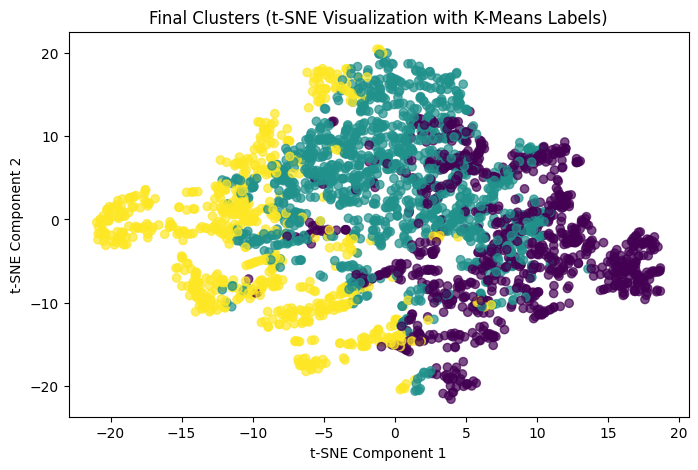

In [11]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis

This analysis involved clustering unlabeled sound data using Mel Spectrogram features. The process highlighted the critical role of dimensionality reduction and the comparative performance of different clustering algorithms.

-   **Why dimensionality reduction helped in clustering:**
    Dimensionality reduction was indispensable for this task due to the high dimensionality (128 features) of the extracted Mel Spectrograms.
    * **Visualization:** Directly visualizing the raw 128-dimensional data was impractical, as demonstrated by the uninterpretable scatter plot of two features and the computationally heavy, cluttered pair plot of just five features. Dimensionality reduction techniques like PCA and t-SNE transformed this high-dimensional space into a manageable 2D/3D representation, enabling us to visually inspect for potential clusters and understand the data's inherent structure.
    * **Algorithm Performance:** While not directly assessed for computational speed in this assignment, high-dimensional data can negatively impact clustering algorithms by increasing computation time and making distance metrics less meaningful (the "Curse of Dimensionality"). Reducing dimensions helps mitigate these issues.

-   **Justify why certain clustering methods worked better:**
    * **K-Means:** K-Means was effective in partitioning the data into distinct clusters, even if they were not perfectly separated, as indicated by its moderate silhouette score (0.1684) and Davies-Bouldin Index (1.7438). The elbow method suggested 3 or 4 clusters, and K-Means successfully identified 3 clusters, providing a plausible grouping of the sound data. Its performance is robust when clusters are somewhat spherical and equally sized, which might be approximated in the reduced space.
    * **DBSCAN:** In contrast, DBSCAN, with its initial parameter settings (`eps=0.5`, `min_samples=5`), failed entirely to identify any clusters, classifying all 3000 data points as noise. This highlights DBSCAN's strong reliance on proper parameter tuning for the dataset's specific density. Without careful selection of `eps` and `min_samples` (e.g., via a k-distance plot), DBSCAN can be ineffective in discovering clusters, especially in varying density datasets or when `eps` is too small. For this dataset, DBSCAN would require extensive tuning to yield any meaningful clusters.

-   **Relate findings to real-world clustering challenges:**
    This assignment reflects common challenges in real-world unsupervised learning tasks, such as:
    * **High-Dimensionality:** Many real-world datasets (e.g., image features, text embeddings, audio features) are inherently high-dimensional, making direct analysis and visualization difficult. Dimensionality reduction is almost always a prerequisite.
    * **Algorithm Selection & Tuning:** There's no one-size-fits-all clustering algorithm. K-Means (partitioning-based) performed adequately for this dataset, while DBSCAN (density-based) struggled without tuning. Selecting the right algorithm depends on the data's underlying structure (e.g., spherical vs. arbitrary shapes, varying densities).
    * **Lack of Ground Truth:** Since the data is unlabeled, evaluating cluster quality relies on intrinsic metrics (Silhouette, Davies-Bouldin) and visual interpretability. This is a significant challenge in real-world scenarios where subjective interpretation often complements objective metrics.
    * **Feature Engineering:** The quality of initial features (Mel Spectrograms) directly impacts clustering success. Robust feature engineering is fundamental to extracting meaningful patterns from raw data.